# Load your trained CNN and understand what exactly it’s learning

## Import Packages

In [1]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.datasets import mnist
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools as it

physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) >= 1:
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1. Load your trained MNIST model

In [2]:
model = tf.keras.models.load_model("classify_mnist.h5")

## 2. Analyze the models’ performance by viewing the Confusion Matrix and Classification Report

In [3]:
# fetch and format test data
_, (test_images, test_labels) = mnist.load_data()

x_test = tf.reshape(test_images, [len(test_images), 28, 28, 1])
x_test = tf.cast(x_test, dtype=tf.float32) / 255

In [4]:
# tutorial for generating cnn analysis https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
# get predictions for all test data
preds = model.predict(x_test)

In [5]:
labels = [0,1,2,3,4,5,6,7,8,9]
y_act = test_labels
y_pred = tf.math.argmax(preds, 1).numpy()

In [6]:
# Difference between Accuracy, precision, recall, and f1 https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9    
classification_metrics = metrics.classification_report(y_act, y_pred)
print(classification_metrics)

precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.98      0.98       892
           6       1.00      0.98      0.99       958
           7       1.00      0.97      0.98      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [7]:
confusion_matrix = metrics.confusion_matrix(y_act, y_pred, labels=labels, normalize=None)


In [8]:
print(confusion_matrix)

[[ 978    0    0    0    0    0    2    0    0    0]
 [   0 1127    4    1    1    1    0    0    1    0]
 [   3    0 1025    0    1    0    0    0    3    0]
 [   1    0    3 1003    0    2    0    0    1    0]
 [   0    0    3    0  975    0    0    0    2    2]
 [   2    0    1    8    0  877    2    0    0    2]
 [   3    2    0    1    2    6  943    0    1    0]
 [   0    2   21    3    1    0    0  997    1    3]
 [   3    0    2    1    1    1    0    1  963    2]
 [   1    2    0    3    8    8    0    1    7  979]]


### Performance Weaknesses

- With respect to precision, the model over predicted images were the number "two" when they were not. "3", "5", and "8" were also low precision
- With respect to recall, the model did not recognise "7" the most, misclissifying it the most as a "2". "9" was also difficult for the model to recognize, classifying it was a "4", "5", or "8" by mistake

## 3. Identify all samples wrongly classified by the CNN and display them

In [9]:
incorrect_predictions = []

for idx, (actual_val, predicted_val) in enumerate(zip(y_act, y_pred)):
    if actual_val != predicted_val:
        incorrect_predictions.append(idx)

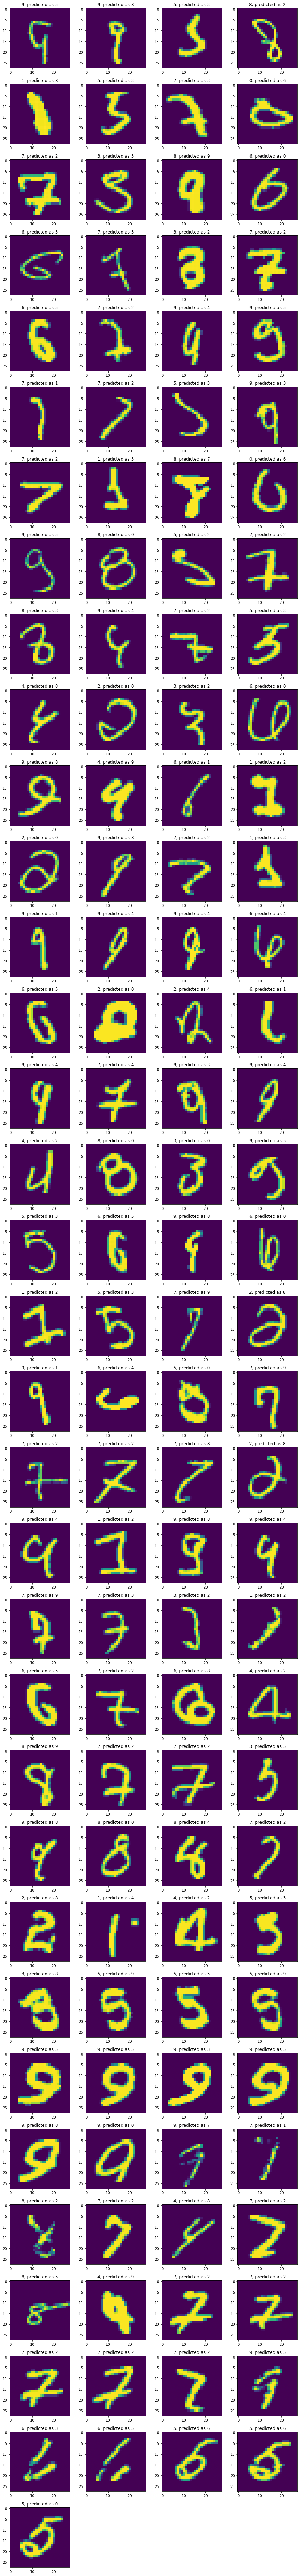

In [10]:
images_to_show = len(incorrect_predictions)
columns = 4
rows = (images_to_show // columns) + 1

fig = plt.figure(figsize=(12, 100))

for img_idx in range(images_to_show):
    instance = incorrect_predictions[img_idx]
    title = "{}, predicted as {}".format(y_act[instance], y_pred[instance])    
    img = test_images[instance]

    img_plot = fig.add_subplot(rows, columns, img_idx+1)

    img_plot.set_title(title)
    img_plot.imshow(img)

plt.tight_layout()
plt.show(fig)

## 4. Extract layer outputs and create our activation model

code snippets from ch5 Deep Learning with Python by François Chollet

In [11]:
layer_outputs = [layer.output for layer in model.layers[:3]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)


In [12]:
activations = activation_model.predict(tf.convert_to_tensor([x_test[0]]))

## 5. Display the output shape of the first layer activation and compare it with the output layer shape that can be seen from displaying the model summary

In [13]:
model.summary()

Model: "mnist"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
dense (Dense)                (None, 12, 12, 128)       4224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0     

In [14]:
tf.shape(activations[0])

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 1, 26, 26, 64], dtype=int32)>

## 6. Show the output of the activation map of the fourth convolution filter or feature map in the first convolution layer

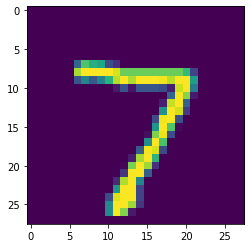

In [15]:
plt.imshow(x_test[0])

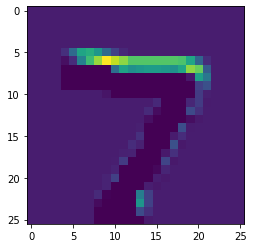

In [16]:
convolution_layer_idx = 0
convolution_filter_idx = 3
plt.imshow(activations[convolution_layer_idx][0, :, :, convolution_filter_idx])

## 7. Display all the activations for the first three layers of the model (in other words, the two convolution layers and the max-pooling layer)

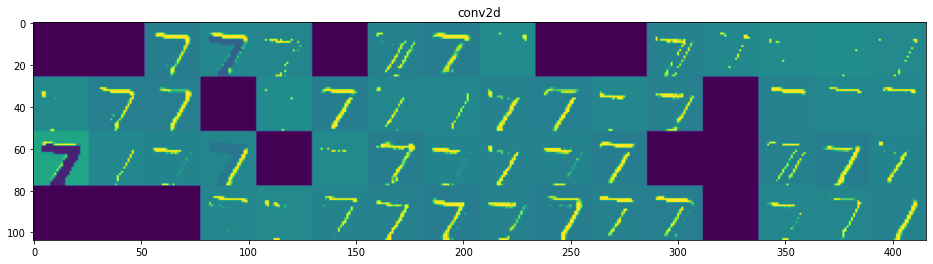

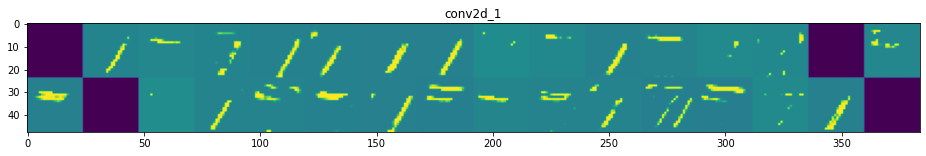

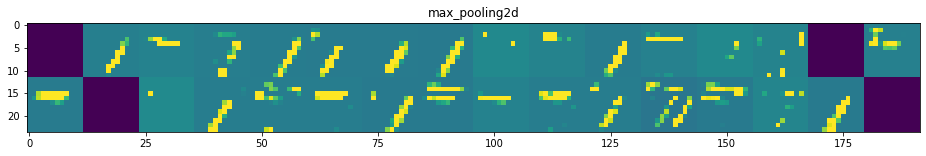

In [17]:
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]

    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

